In [57]:
import requests
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, List

In [69]:
# seasons = ["2425", "2324", "2223", "2122", "2021", "1920", "1819", "1718", "1617", "1516"]  # target seasons
seasons = ["2021", "1920", "1819", "1718", "1617", "1516", "1415", "1314", "1213"]  # target seasons
divisions = ["E0", "E1", "E2", "E3"]  # English leagues
base_dir = Path("../data/soccer/pl")
base_dir.mkdir(parents=True, exist_ok=True)  # create directory if not exists

files = []
for s in seasons:
    for d in divisions:
        url = f"https://www.football-data.co.uk/mmz4281/{s}/{d}.csv"  # data source url
        dest = base_dir / f"{s}_{d}.csv"  # local file path
        try:
            r = requests.get(url, timeout=30)  # download file
            r.raise_for_status()  # check for HTTP errors
            dest.write_bytes(r.content)  # save file
            files.append((s, d, dest))
            print(f"downloaded {d} {s} -> {dest.name}")
        except Exception as e:
            print(f"skip {d} {s}: {e}")

downloaded E0 2021 -> 2021_E0.csv
downloaded E1 2021 -> 2021_E1.csv
downloaded E2 2021 -> 2021_E2.csv
downloaded E3 2021 -> 2021_E3.csv
downloaded E0 1920 -> 1920_E0.csv
downloaded E1 1920 -> 1920_E1.csv
downloaded E2 1920 -> 1920_E2.csv
downloaded E3 1920 -> 1920_E3.csv
downloaded E0 1819 -> 1819_E0.csv
downloaded E1 1819 -> 1819_E1.csv
downloaded E2 1819 -> 1819_E2.csv
downloaded E3 1819 -> 1819_E3.csv
downloaded E0 1718 -> 1718_E0.csv
downloaded E1 1718 -> 1718_E1.csv
downloaded E2 1718 -> 1718_E2.csv
downloaded E3 1718 -> 1718_E3.csv
downloaded E0 1617 -> 1617_E0.csv
downloaded E1 1617 -> 1617_E1.csv
downloaded E2 1617 -> 1617_E2.csv
downloaded E3 1617 -> 1617_E3.csv
downloaded E0 1516 -> 1516_E0.csv
downloaded E1 1516 -> 1516_E1.csv
downloaded E2 1516 -> 1516_E2.csv
downloaded E3 1516 -> 1516_E3.csv
downloaded E0 1415 -> 1415_E0.csv
downloaded E1 1415 -> 1415_E1.csv
downloaded E2 1415 -> 1415_E2.csv
downloaded E3 1415 -> 1415_E3.csv
downloaded E0 1314 -> 1314_E0.csv
downloaded E1 

In [70]:
# Store data in a dictionary by season and league
data_dict = {}
for s, d, fp in files:
    try:
        df = pd.read_csv(fp, encoding="latin-1", low_memory=False,
                         parse_dates=["Date"], date_format="%d/%m/%Y")
        df["season"] = s
        df["division"] = d
        
        # 시즌별 딕셔너리가 없으면 생성
        if s not in data_dict:
            data_dict[s] = {}
        
        # 시즌 > 디비전 구조로 저장
        data_dict[s][d] = df
    except Exception as e:
        print(f"read fail {fp.name}: {e}")

print(f"\nTotal {len(data_dict)} seasons loaded.")
print("Data dictionary structure:")
for season in data_dict.keys():
    print(f"  Season {season}:")
    for division in data_dict[season].keys():
        print(f"    {division}: {data_dict[season][division].shape}")


Total 9 seasons loaded.
Data dictionary structure:
  Season 2021:
    E0: (380, 108)
    E1: (552, 108)
    E2: (552, 108)
    E3: (552, 108)
  Season 1920:
    E0: (380, 108)
    E1: (552, 108)
    E2: (400, 108)
    E3: (440, 108)
  Season 1819:
    E0: (380, 64)
    E1: (552, 64)
    E2: (552, 64)
    E3: (552, 64)
  Season 1718:
    E0: (380, 67)
    E1: (552, 67)
    E2: (552, 67)
    E3: (552, 67)
  Season 1617:
    E0: (380, 67)
    E1: (552, 67)
    E2: (552, 67)
    E3: (552, 67)
  Season 1516:
    E0: (380, 67)
    E1: (552, 67)
    E2: (553, 67)
    E3: (553, 67)
  Season 1415:
    E0: (381, 70)
    E1: (553, 70)
    E2: (552, 70)
    E3: (552, 70)
  Season 1314:
    E0: (380, 70)
    E1: (552, 70)
    E2: (552, 70)
    E3: (552, 70)
  Season 1213:
    E0: (380, 76)
    E1: (552, 75)
    E2: (553, 75)
    E3: (554, 75)


# 1. Ver1. SIAM Website
https://www.siam.org/publications/siam-news/articles/feeling-lucky-the-relative-roles-of-skill-and-chance-in-sports/

In [71]:
def _ensure_datetime(df: pd.DataFrame):
    if not np.issubdtype(df["Date"].dtype, np.datetime64):
        df = df.copy()
        # df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y", errors="coerce")
    return df

def _team_rows(df: pd.DataFrame, team: str) -> pd.DataFrame:
    # Build per-team match list with perspective columns
    home = df[df["HomeTeam"]==team].copy()
    away = df[df["AwayTeam"]==team].copy()
    home["gf"] = home["FTHG"]; home["ga"] = home["FTAG"]; home["venue"] = "H"
    away["gf"] = away["FTAG"]; away["ga"] = away["FTHG"]; away["venue"] = "A"
    # points and outcomes
    goal_diff = home["gf"] - home["ga"]
    home["win"]  = (goal_diff > 0).astype(int)
    home["draw"] = (goal_diff == 0).astype(int)
    home["loss"] = (goal_diff < 0).astype(int)
    home["pts"]  = home["win"]*3 + home["draw"]*1

    goal_diff = away["gf"] - away["ga"]
    away["win"]  = (goal_diff > 0).astype(int)
    away["draw"] = (goal_diff == 0).astype(int)
    away["loss"] = (goal_diff < 0).astype(int)
    away["pts"]  = away["win"]*3 + away["draw"]*1

    # Unify
    home_part = home[["Date","venue","gf","ga","win","draw","loss","pts"]]
    away_part = away[["Date","venue","gf","ga","win","draw","loss","pts"]]
    t = pd.concat([home_part, away_part], ignore_index=True)
    t = t.sort_values("Date")
    return t

def _half_metric(rows: pd.DataFrame, metric_mode: str="ppg") -> tuple:
    n = len(rows)
    if n == 0:
        return np.nan, np.nan
    k = n//2  # first k matches as "first half", rest as "second half"; if odd, second half gets +1
    first = rows.iloc[:k]
    second = rows.iloc[k:]
    if metric_mode == "ppg":
        # Points per game normalized to [0,1]: ppg / 3
        x = (first["pts"].sum() / max(1, len(first))) / 3.0
        y = (second["pts"].sum() / max(1, len(second))) / 3.0
    elif metric_mode == "winfrac":
        # Win fraction: wins / matches (draws count as 0)
        x = first["win"].sum() / max(1, len(first))
        y = second["win"].sum() / max(1, len(second))
    else:
        raise ValueError("metric_mode must be 'ppg' or 'winfrac'")
    return float(x), float(y)

def compute_siam_R(data_dict: Dict[str, Dict[str, pd.DataFrame]], metric_mode: str="ppg"):
    rows = []
    for season, divmap in data_dict.items():
        for division, df in divmap.items():
            df = _ensure_datetime(df)
            df = df.dropna(subset=['HomeTeam', 'AwayTeam'])
            teams = sorted(set(df["HomeTeam"]).union(set(df["AwayTeam"])))
            xy = []
            for team in teams:
                trows = _team_rows(df, team)
                x, y = _half_metric(trows, metric_mode=metric_mode)
                if np.isfinite(x) and np.isfinite(y):
                    xy.append((x,y))
            if len(xy) < 3:
                continue
            X = np.array([u for u,v in xy], dtype=float)
            Y = np.array([v for u,v in xy], dtype=float)
            # Rotate by 45 degrees: S=(X+Y)/sqrt(2), T=(Y-X)/sqrt(2)
            S = (X + Y) / np.sqrt(2.0)
            T = (Y - X) / np.sqrt(2.0)
            A = float(np.var(S, ddof=0))
            B = float(np.var(T, ddof=0))
            if A <= 1e-12:
                R = np.nan
            else:
                R = 1.0 - (B / A)
            rows.append({"division": division, "season": season, "teams": len(xy),
                         "metric_mode": metric_mode, "A_var_S": A, "B_var_T": B, "R": R})
    out = pd.DataFrame(rows).sort_values(["division","season"])
    return out

In [72]:
res_ppg = compute_siam_R(data_dict, metric_mode="ppg")

In [73]:
divcode2divname = {
    'E0': 'Premier League',
    'E1': 'Championship',
    'E2': 'League One',
    'E3': 'League Two'
}
res_ppg["division"] = res_ppg["division"].map(divcode2divname)
res_ppg.head()

,division,season,teams,metric_mode,A_var_S,B_var_T,R
32,Premier League,1213,20,ppg,0.046420,0.005940,0.872033
28,Premier League,1314,20,ppg,0.054307,0.006208,0.885687
24,Premier League,1415,20,ppg,0.039078,0.004763,0.878125
20,Premier League,1516,20,ppg,0.034846,0.011380,0.673416
16,Premier League,1617,20,ppg,0.057612,0.011005,0.808981


/tmp/ipykernel_1768100/2951594005.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, vert=False, labels=order, manage_ticks=True, whis=[5,95], showmeans=True)


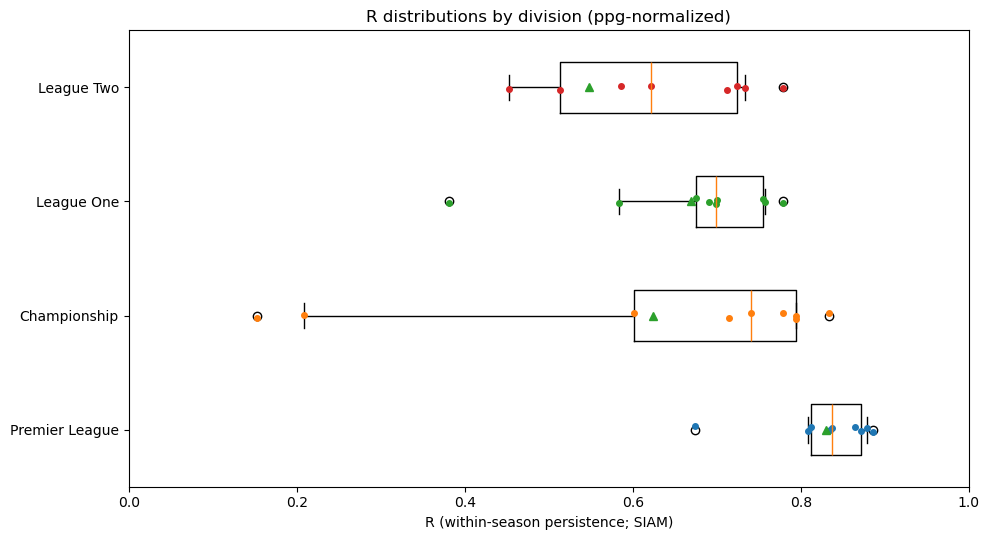

In [74]:
def plot_siam_R_boxplot(df: pd.DataFrame, metric_mode: str = "ppg"):
    df = res_ppg.copy()
    if "metric_mode" in df.columns:
        df = df[df["metric_mode"].astype(str).str.lower()=="ppg"]

    # division 정렬: 중앙값 R 높은 순
    order = (df.groupby("division")["R"]
            .median()
            .sort_values(ascending=False)
            .index
            .tolist())

    # 박스플롯 데이터와 점들 준비
    data = [df[df["division"]==div]["R"].dropna().values for div in order]

    plt.figure(figsize=(10, 5.5))
    # 수평 박스플롯(단일 차트, 색상 지정 안 함)
    bp = plt.boxplot(data, vert=False, labels=order, manage_ticks=True, whis=[5,95], showmeans=True)

    # 시즌별 점 오버레이
    for yi, div in enumerate(order, start=1):
        vals = df[df["division"]==div]["R"].dropna().values
        if len(vals)==0: 
            continue
        y = np.full_like(vals, yi, dtype=float) + (np.random.rand(len(vals))-0.5)*0.06  # 살짝 지터
        plt.plot(vals, y, "o", markersize=4)

    plt.xlabel("R (within-season persistence; SIAM)")
    plt.title(f"R distributions by division ({metric_mode}-normalized)")
    plt.xlim(0, 1)
    plt.tight_layout()

    # out_path = Path("/mnt/data/siam_R_boxplot.png")
    # plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()

    # print("Saved to:", out_path)

plot_siam_R_boxplot(res_ppg, metric_mode="ppg")

/tmp/ipykernel_1768100/2951594005.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, vert=False, labels=order, manage_ticks=True, whis=[5,95], showmeans=True)


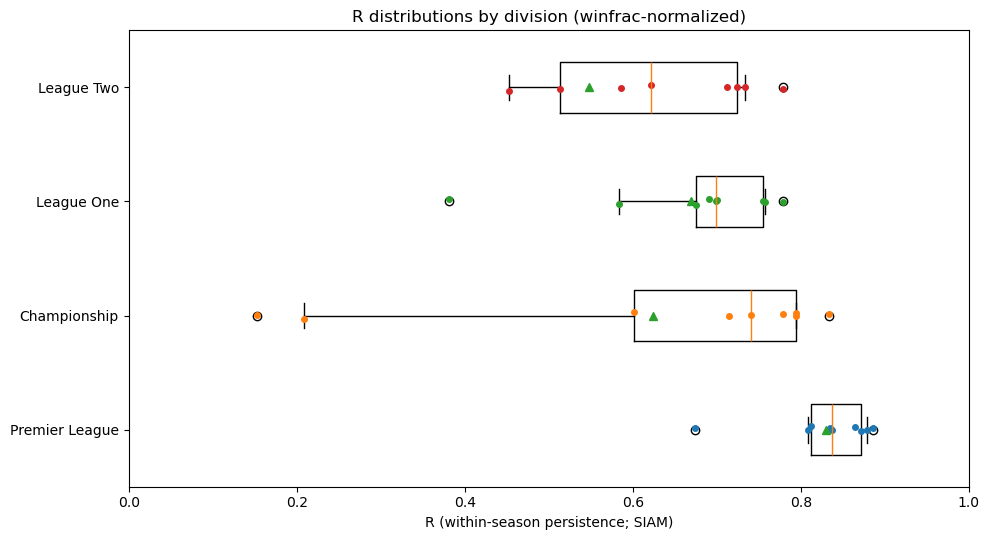

In [75]:
res_winfrac = compute_siam_R(data_dict, metric_mode="winfrac")
plot_siam_R_boxplot(res_winfrac, metric_mode="winfrac")

# 2. Ver2. Fantasy League Paper Style



In [51]:
# Re-defining the R-value computation utilities (execution retry)
def _season_key(s):
    try:
        return int(str(s)[:4])
    except Exception:
        return s

def build_team_season_table(
    data_dict: Dict[str, Dict[str, pd.DataFrame]],
    points_win: int = 3, points_draw: int = 1, points_loss: int = 0
) -> pd.DataFrame:
    rows = []
    for season, div_map in data_dict.items():
        for division, df in div_map.items():
            needed = {"HomeTeam","AwayTeam","FTHG","FTAG"}
            if not needed.issubset(set(df.columns)):
                raise ValueError(f"{division} {season}: missing required columns {needed - set(df.columns)}")
            h = df.copy()
            h["team"] = h["HomeTeam"]
            h["gf"] = h["FTHG"]
            h["ga"] = h["FTAG"]
            a = df.copy()
            a["team"] = a["AwayTeam"]
            a["gf"] = a["FTAG"]
            a["ga"] = a["FTHG"]
            t = pd.concat([h[["team","gf","ga"]], a[["team","gf","ga"]]], ignore_index=True)
            outcome = np.sign(t["gf"] - t["ga"])
            pts = np.where(outcome>0, points_win, np.where(outcome==0, points_draw, points_loss))
            t["pts"] = pts
            t["gd"]  = t["gf"] - t["ga"]
            g = t.groupby("team", as_index=False).agg(pts=("pts","sum"),
                                                     gd=("gd","sum"),
                                                     mp=("pts","count"))
            g["division"] = division
            g["season"] = season
            rows.append(g[["division","season","team","pts","gd","mp"]])
    panel = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["division","season","team","pts","gd","mp"])
    return panel

def _adjacent_pairs(seasons: List[str]) -> List[Tuple[str,str]]:
    ss = sorted(seasons, key=_season_key)
    return list(zip(ss[:-1], ss[1:]))

def r_values_by_division(panel: pd.DataFrame, metric: str = "pts") -> Tuple[pd.DataFrame, pd.DataFrame]:
    if metric not in {"pts","gd"}:
        raise ValueError("metric must be 'pts' or 'gd'")
    details = []
    for division, df in panel.groupby("division"):
        seasons = df["season"].unique().tolist()
        for s0, s1 in _adjacent_pairs(seasons):
            a = df[df.season==s0][["team", metric]].rename(columns={metric: f"{metric}_t"})
            b = df[df.season==s1][["team", metric]].rename(columns={metric: f"{metric}_t1"})
            m = a.merge(b, on="team", how="inner")
            if len(m)>=3 and m[f"{metric}_t"].std(ddof=0)>0 and m[f"{metric}_t1"].std(ddof=0)>0:
                r = np.corrcoef(m[f"{metric}_t"], m[f"{metric}_t1"])[0,1]
                details.append({
                    "division": division,
                    "season_pair": f"{s0}→{s1}",
                    "metric": metric,
                    "teams_overlap": len(m),
                    "r": r
                })
    details_df = pd.DataFrame(details)
    if details_df.empty:
        return pd.DataFrame(columns=["division","metric","mean_r","pairs"]), details_df
    summary = details_df.groupby(["division","metric"], as_index=False).agg(mean_r=("r","mean"),
                                                                            pairs=("r","count"))
    return summary, details_df

def bootstrap_ci(x: np.ndarray, iters: int = 2000, alpha: float = 0.05, seed: int = 123) -> Tuple[float,float,float]:
    rng = np.random.default_rng(seed)
    x = np.array(x, dtype=float)
    if len(x)==0:
        return np.nan, np.nan, np.nan
    boots = [rng.choice(x, size=len(x), replace=True).mean() for _ in range(iters)]
    mu = float(x.mean())
    lo = float(np.quantile(boots, alpha/2))
    hi = float(np.quantile(boots, 1-alpha/2))
    return mu, lo, hi

def r_values_with_ci(panel: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    out_rows = []
    all_details = []
    for metric in ["pts","gd"]:
        summary, details = r_values_by_division(panel, metric=metric)
        all_details.append(details)
        for _, row in summary.iterrows():
            div = row["division"]
            subset = details[(details["division"]==div) & (details["metric"]==metric)]["r"].values
            mu, lo, hi = bootstrap_ci(subset, iters=2000, alpha=0.05, seed=123)
            out_rows.append({"division": div, "metric": metric, "mean_r": mu, "ci_lo": lo, "ci_hi": hi, "pairs": len(subset)})
    return pd.DataFrame(out_rows), pd.concat(all_details, ignore_index=True) if len(all_details) else pd.DataFrame()

In [52]:
panel = build_team_season_table(data_dict, points_win=3, points_draw=1, points_loss=0)
summary_ci, details = r_values_with_ci(panel)

In [53]:
panel.head()

,division,season,team,pts,gd,mp
0,E0,2425,Arsenal,74,35.0,38
1,E0,2425,Aston Villa,66,7.0,38
2,E0,2425,Bournemouth,56,12.0,38
3,E0,2425,Brentford,56,9.0,38
4,E0,2425,Brighton,61,7.0,38


In [54]:
summary_ci.head()

,division,metric,mean_r,ci_lo,ci_hi,pairs
0,E0,pts,0.688370,0.594571,0.778530,9
1,E1,pts,0.351721,0.186604,0.479518,9
2,E2,pts,0.365526,0.235052,0.496126,9
3,E3,pts,0.354850,0.201728,0.519046,9
4,E0,gd,0.759887,0.692095,0.820119,9


In [55]:
details.head()

,division,season_pair,metric,teams_overlap,r
0,E0,1516→1617,pts,17,0.465256
1,E0,1617→1718,pts,17,0.827311
2,E0,1718→1819,pts,17,0.871352
3,E0,1819→1920,pts,17,0.843953
4,E0,1920→2021,pts,17,0.540836


In [77]:
panel['devision'] = panel['division'].map(divcode2divname)
summary_ci['division'] = summary_ci['division'].map(divcode2divname)
details['division'] = details['division'].map(divcode2divname)

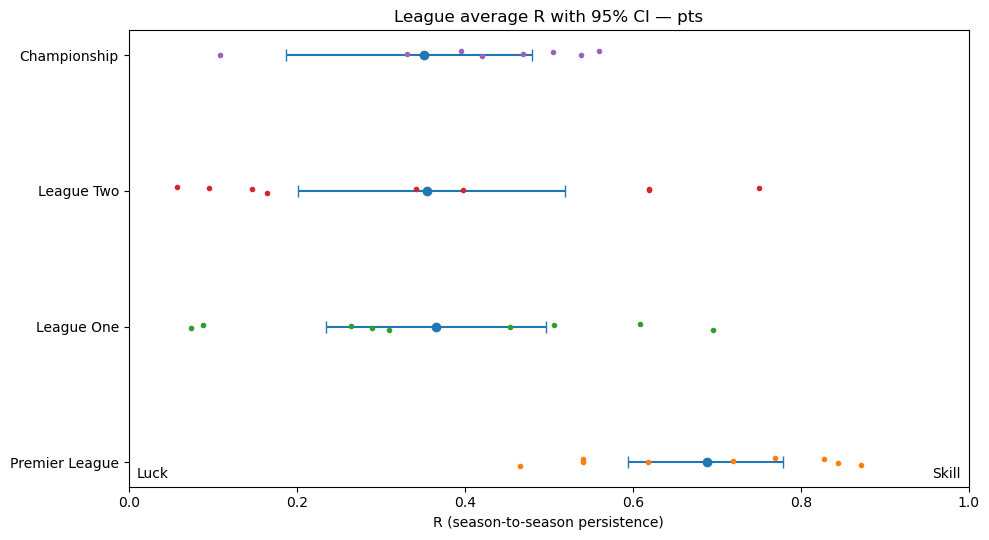

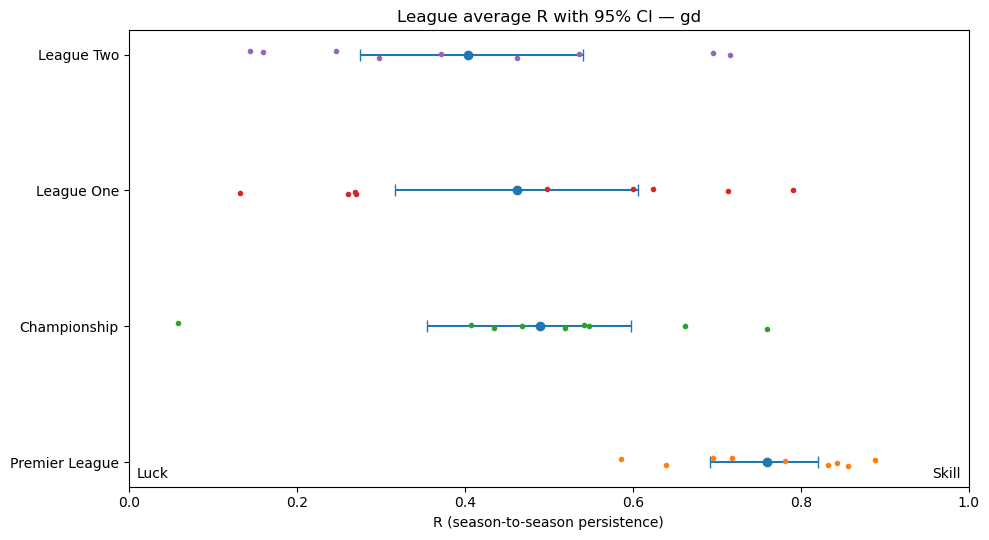

In [78]:
def plot_siam_style_from_summary(summary_ci, details, metric="pts", outfile="/mnt/data/siam_style_R_{metric}.png"):
    
    s = summary_ci[summary_ci["metric"]==metric].copy()
    d = details[details["metric"]==metric].copy()
    if s.empty or d.empty:
        raise ValueError(f"No data for metric='{metric}'.")

    s = s.sort_values("mean_r", ascending=False).reset_index(drop=True)
    divisions = s["division"].tolist()
    y = np.arange(1, len(divisions)+1)

    means = s["mean_r"].values
    xerr = np.vstack([means - s["ci_lo"].values, s["ci_hi"].values - means])

    plt.figure(figsize=(10, 5.5))
    plt.errorbar(means, y, xerr=xerr, fmt='o', capsize=4)     # 평균 + 95% CI

    # 시즌쌍 r 점 오버레이(가벼운 지터)
    for yi, div in zip(y, divisions):
        vals = d[d["division"]==div]["r"].dropna().values
        if len(vals)==0: 
            continue
        xx = vals
        yy = np.full_like(vals, yi, dtype=float) + (np.random.rand(len(vals))-0.5)*0.06
        plt.plot(xx, yy, "o", markersize=3)

    plt.yticks(y, divisions)
    plt.xlim(0, 1)
    plt.xlabel("R (season-to-season persistence)")
    plt.title(f"League average R with 95% CI — {metric}")
    plt.annotate("Luck",  xy=(0.01, 0.02), xycoords=("axes fraction","axes fraction"))
    plt.annotate("Skill", xy=(0.99, 0.02), xycoords=("axes fraction","axes fraction"), ha="right")
    plt.tight_layout()
    # out = Path(outfile.format(metric=metric))
    # plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()
    # print("Saved to:", out)

# 실행 (두 장 저장: 승점/골득실)
plot_siam_style_from_summary(summary_ci, details, metric="pts", outfile="/mnt/data/siam_style_R_{metric}.png")
plot_siam_style_from_summary(summary_ci, details, metric="gd",  outfile="/mnt/data/siam_style_R_{metric}.png")
